In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import logging
import pathlib
from datetime import datetime

from graddft_qnn.helper.initialization import batched

import grad_dft as gd
import jax
import numpy as np
import pandas as pd
import pennylane as qml
import tqdm
import yaml
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adamw

from datasets import DatasetDict
from graddft_qnn import helper
from graddft_qnn.cube_dataset.h2_multibond import H2MultibondDataset
from graddft_qnn.dft_qnn import DFTQNN

# from graddft_qnn.helper import training
from graddft_qnn.io.ansatz_io import AnsatzIO
from graddft_qnn.naive_dft_qnn import NaiveDFTQNN
from graddft_qnn.qnn_functional import QNNFunctional
from graddft_qnn.unitary_rep import O_h, is_group

logging.getLogger().setLevel(logging.INFO)
np.random.seed(42)
key = PRNGKey(42)

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
with open("config.yaml") as file:
    data = yaml.safe_load(file)
    num_qubits = data["GROUP"]["QBITS"]
    size = np.cbrt(2**num_qubits)
    assert size.is_integer()
    size = int(size)
    n_epochs = data["TRAINING"]["N_EPOCHS"]
    learning_rate = data["TRAINING"]["LEARNING_RATE"]
    momentum = data["TRAINING"]["MOMENTUM"]
    num_gates = data["N_GATES"]
    eval_per_x_epoch = data["TRAINING"]["EVAL_PER_X_EPOCH"]
    batch_size = data["TRAINING"]["BATCH_SIZE"]
    check_group = data["CHECK_GROUP"]
    flag_meanfield = data["FLAG_MEANFIELD"]
    assert (
        isinstance(num_gates, int) or num_gates == "full"
    ), f"N_GATES must be integer or 'full', got {num_gates}"
    full_measurements = "prob"
    group: list = data["GROUP"]
    group_str_rep = "]_[".join(group)[:230]
    if "naive" not in group["MEMBERS"]:
        group_matrix_reps = [getattr(O_h, gr)(size, False) for gr in group["MEMBERS"]]
        if (check_group) and (not is_group(group_matrix_reps, group)):
            raise ValueError("Not forming a group")
    xc_functional_name = data["XC_FUNCTIONAL"]
    dev = qml.device("default.qubit", wires=num_qubits)


In [86]:
filename = f"ansatz_{num_qubits}_{group_str_rep}_qubits"
layers = {0: [], 1: [], 2: []}
for layer in [0]:
    for wires in batched(range(0, 9), 3):
        layers[layer].append(DFTQNN.gate_design(
            len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=wires[0])], wires=wires
        )[0])

Creating invariant gates generator:  12%|█████████████▏                                                                                           | 8/64 [00:00<00:00, 319.79it/s]


In [87]:
layers[0]

[0.5 * (I(0) @ X(1) @ X(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(I(0) @ X(1) @ X(2))) + (I(0) @ I(1)) @ I(2) @ X(0) @ X(1) @ X(2) @ (Adjoint((I(0) @ I(1)) @ I(2)))),
 0.5 * (I(3) @ X(4) @ X(5) @ X(3) @ X(4) @ X(5) @ (Adjoint(I(3) @ X(4) @ X(5))) + (I(0) @ I(1)) @ I(2) @ X(3) @ X(4) @ X(5) @ (Adjoint((I(0) @ I(1)) @ I(2)))),
 0.5 * (I(6) @ X(7) @ X(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(I(6) @ X(7) @ X(8))) + (I(0) @ I(1)) @ I(2) @ X(6) @ X(7) @ X(8) @ (Adjoint((I(0) @ I(1)) @ I(2))))]

In [ ]:
layer_1 = DFTQNN.gate_design(
    len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)], wires=[3, 4, 5]
)

In the first layer of the EQCNN, equivariant convolutional and pooling layers can be built if $U_1$ (conv) and $V_1$ (pooling) commutes with all the possible three-qubit local group representations within $G$ which are

- 180 deg $x$ rotation: ${I \otimes I \otimes I, I \otimes I \otimes X, I \otimes X \otimes X, X \otimes X \otimes X}$
- 180 deg $y$ rotation: ${X \otimes I \otimes X, X \otimes X \otimes I, X \otimes I \otimes I, X \otimes X \otimes X}$
- 180 deg $z$ rotation: (shared with above) ${X \otimes X \otimes X, X \otimes X \otimes I, X \otimes I \otimes I, I \otimes I \otimes I}$

In [90]:
representations = qml.I(0) @ qml.I(1) @ qml.X(2), qml.X(0) @ qml.X(1) @ qml.X(2), qml.X(0) @ qml.I(1) @ qml.X(2), qml.X(0) @ qml.X(1) @ qml.I(2), qml.X(0) @ qml.I(1) @ qml.I(2), qml.I(0) @ qml.X(1) @ qml.X(2)
for representation in tqdm.tqdm(representations):
    assert qml.matrix(qml.commutator(qml.exp(-1j *  layers[0][1]), representation)).max() < 1e-10
    assert qml.matrix(qml.commutator(qml.exp(-1j *  layers[0][1]), representation)).min() > -1e-10

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1412.38it/s]


In [100]:
DFTQNN.gate_design(
        len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=wires[0])], wires=wires
    )[0]

Creating invariant gates generator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 654.14it/s]


0.5 * (I(6) @ X(7) @ X(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(I(6) @ X(7) @ X(8))) + (I(0) @ I(1)) @ I(2) @ X(6) @ X(7) @ X(8) @ (Adjoint((I(0) @ I(1)) @ I(2))))

In [109]:
DFTQNN.gate_design(
        len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)], wires=[0,1,2]
    )[0]

Creating invariant gates generator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 823.36it/s]


0.5 * (I(0) @ X(1) @ X(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(I(0) @ X(1) @ X(2))) + (I(0) @ I(1)) @ I(2) @ X(0) @ X(1) @ X(2) @ (Adjoint((I(0) @ I(1)) @ I(2))))

In [110]:
DFTQNN.gate_design(
        len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)], wires=[3,4,5]
    )[0]

Creating invariant gates generator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 597.51it/s]


0.5 * (I(3) @ X(4) @ X(5) @ X(3) @ X(4) @ X(5) @ (Adjoint(I(3) @ X(4) @ X(5))) + (I(0) @ I(1)) @ I(2) @ X(3) @ X(4) @ X(5) @ (Adjoint((I(0) @ I(1)) @ I(2))))

Creating invariant gates generator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 627.61it/s]


(<Figure size 500x700 with 1 Axes>, <Axes: >)

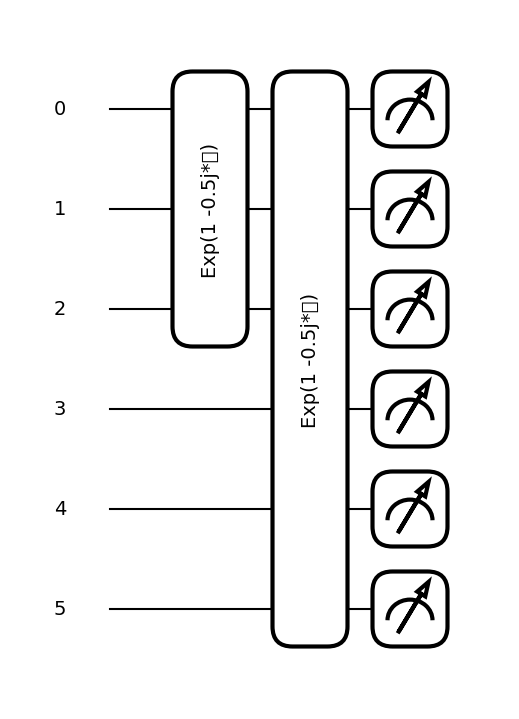

In [106]:
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def circuit():
    qml.exp(-1j * DFTQNN.gate_design(
        len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)], wires=[0,1,2]
    )[0])
    qml.exp(-1j * DFTQNN.gate_design(
        len(dev.wires), [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)], wires=[3,4,5]
    )[0])
    return qml.probs()

qml.draw_mpl(circuit)()

## Pooling

In [61]:
def pool():
    base1 = qml.RX(0.5, wires=0) @ qml.RX(0.5, wires=1)
    controlled1 = qml.ops.op_math.Controlled(base1, control_wires=2, control_values= True)
    base2 = qml.RX(0.5, wires=0) @ qml.RX(0.5, wires=1)
    controlled2 = qml.ops.op_math.Controlled(base2, control_wires=2, control_values= False)
    return controlled1, controlled2

(<Figure size 500x400 with 1 Axes>, <Axes: >)

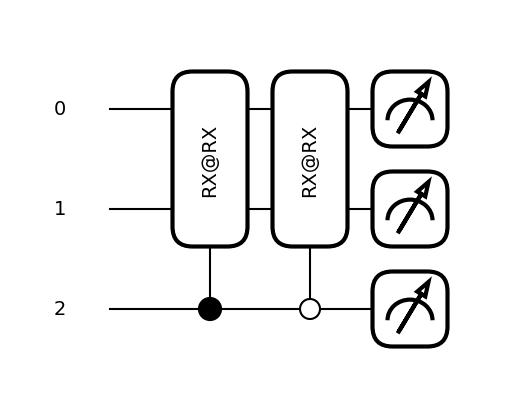

In [66]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit():
    pool()
    return qml.state()

qml.draw_mpl(circuit)()

In [65]:
representations = qml.I(0) @ qml.I(1) @ qml.X(2), qml.X(0) @ qml.X(1) @ qml.X(2)
c1, c2 = pool()
for representation in representations:
    assert qml.matrix(qml.commutator(c1 @ c2, representation)).max() < 1e-10
    assert qml.matrix(qml.commutator(c1 @ c2, representation)).min() > -1e-10